## Comparasion of MSSA and tSSA

Testing on electricity dataset

In [1]:
import numpy as np
import scipy.linalg as linalg
from matplotlib import pyplot as plt
from src.multiD_ssa import multiD_SSA_decomp

%matplotlib inline 

In [2]:
# as in demo, first extract neccessary data

import pandas as pd

raw_data = pd.read_csv("./data/household_power_consumption.csv")
raw_data.rename(columns={'Sub_metering_1': 'kitchen_power', 'Sub_metering_2': 'loundry_power', 'Sub_metering_3': 'heater_conditioner_power'},
                inplace=True)
raw_data.head()

# convert strings to pandas dates
raw_data['Date'] = pd.to_datetime(raw_data['Date'], dayfirst=True)

# slice one year, say 2008
raw_data = raw_data[raw_data['Date'] >= pd.to_datetime('01/01/2008', dayfirst=True)]
raw_data = raw_data[raw_data['Date'] <= pd.to_datetime('30/12/2008', dayfirst=True)]

# drop unnessasary columns
raw_data = raw_data.drop(columns=['Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity'])

# clean data
#print(raw_data['kitchen_power'].__len__())
temp = (raw_data['kitchen_power'].str.find('?') != -1)
temp1 = raw_data['kitchen_power'][temp == True]
raw_data.drop(temp1.index, inplace=True)
# checking successful elimination
#print(raw_data['kitchen_power'].__len__())

temp = (raw_data['loundry_power'].str.find('?') != -1)
temp1 = raw_data['loundry_power'][temp == True]
raw_data.drop(temp1.index, inplace=True)
#print(raw_data['loundry_power'].__len__())

# change type of column to float
raw_data['kitchen_power'] = pd.to_numeric(raw_data['kitchen_power'])
raw_data['loundry_power'] = pd.to_numeric(raw_data['loundry_power'])
raw_data.dtypes

# average information so we have daywise consumption
raw_data = raw_data.groupby('Date').mean()
print(raw_data.head())

data = raw_data.values
data.shape

/tmp/ipykernel_20603/628787485.py:5: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("./data/household_power_consumption.csv")


            kitchen_power  loundry_power  heater_conditioner_power
Date                                                              
2008-01-01       1.709028       1.902083                  8.579861
2008-01-02       0.000000       2.148611                  6.240972
2008-01-03       0.784722       0.587500                  4.632639
2008-01-04       0.861806       3.698611                  8.161111
2008-01-05       1.467361       0.198611                 10.132639


(365, 3)

### MSSA algorithm

Buld trajectory matrices for each 1d signal, stack them into one matrix, apply basic SSA, restore results

In [3]:
from src.oneD_ssa import SSA_decomp
from scipy.linalg import svd

In [4]:
# cut data for the faster computations (not used)
end_day = data.shape[0]
mssa_data = data[:end_day].copy()

# window size for SSA
window_size = 50
# complementary SSA-decomposer
decomposer = SSA_decomp([], window_size)

# building traj. matrices for each signal
traj_matrs = []
for i in range(mssa_data.shape[1]):
    cur_signal = mssa_data[:, i]
    traj_matrs.append(decomposer._build_traj_matrix(cur_signal))
# stack traj. matrices into one
traj_matrix = np.concatenate(traj_matrs, axis=1)

# apply svd
U, s_v, V_tr = svd(traj_matrix)

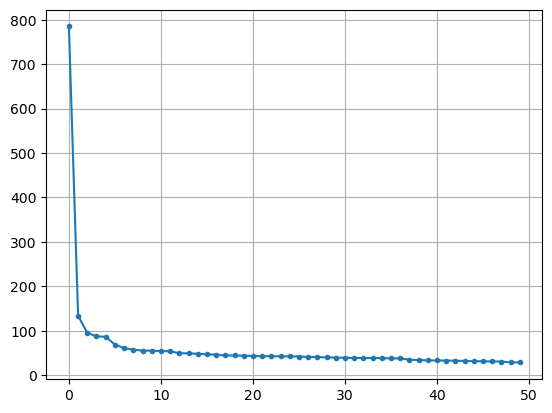

In [5]:
# draw singular values
fig, ax = plt.subplots()
ax.plot(s_v, marker='.')
ax.grid(True)

In [6]:
# now group according to singular values proximities
groups = [(0, ), (1, ), (2, 3, 4), range(5, len(s_v))]
decomposed_signals = []

for group in groups:
    # constructing trajectory matrix for current group
    cur_traj_matr = np.zeros(shape=(U[0].shape[0], V_tr[0].shape[0]), dtype=np.float32)
    # container for decomposed signals out of current group
    cur_decomp_signals = []

    # summing skeletones
    for ind in group:
        cur_traj_matr += s_v[ind] * np.outer(U.transpose()[ind], V_tr[ind])

    # split traj matrix into 3 parts
    cur_traj_submatrs = np.split(cur_traj_matr, 3, axis=1)

    for matrix in cur_traj_submatrs:
        # hankelize
        decomposer._hankelize(matrix)
        # extract time series
        cur_decomp_signals.append(decomposer._extract_ts(matrix))
    
    # save decomposition for each 1d signal for this group
    decomposed_signals.append(cur_decomp_signals)

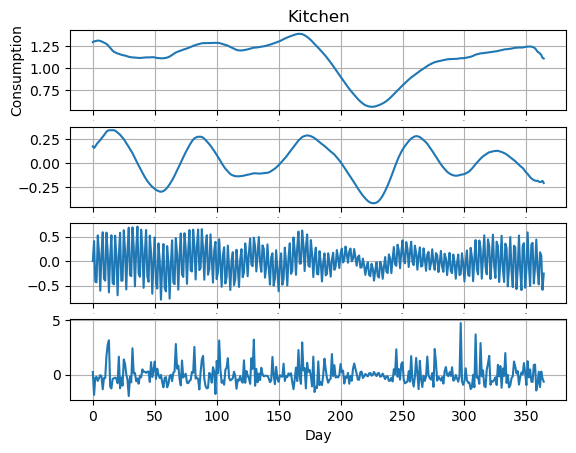

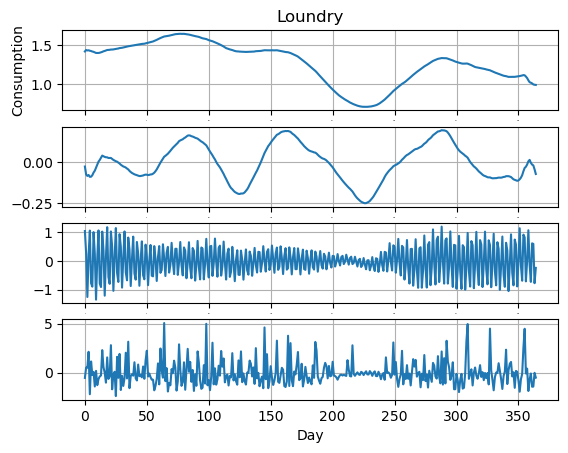

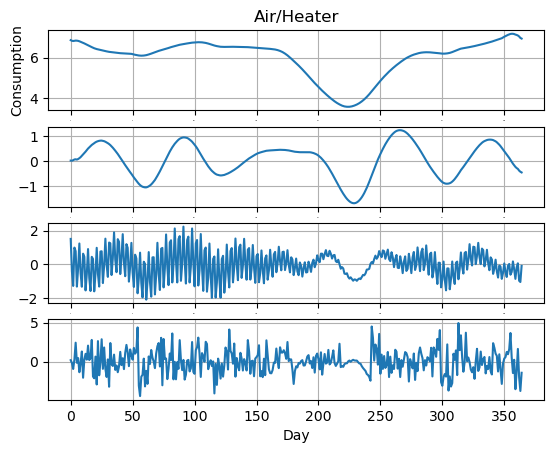

In [7]:
# visualize decompositions
fig_title = ['Kitchen', 'Loundry', 'Air/Heater']

for sig_num in range(3):
    fig, ax = plt.subplots(nrows=len(decomposed_signals))

    for i in range(len(decomposed_signals)):
        ax[i].plot(decomposed_signals[i][sig_num])
        if i == 0:
            ax[i].set_ylabel('Consumption')
            ax[i].set_title(fig_title[sig_num])
        if i == len(decomposed_signals) - 1:
            ax[i].set_xlabel('Day')
        else:
            ax[i].tick_params(axis='x', labelsize=0)

        ax[i].grid()

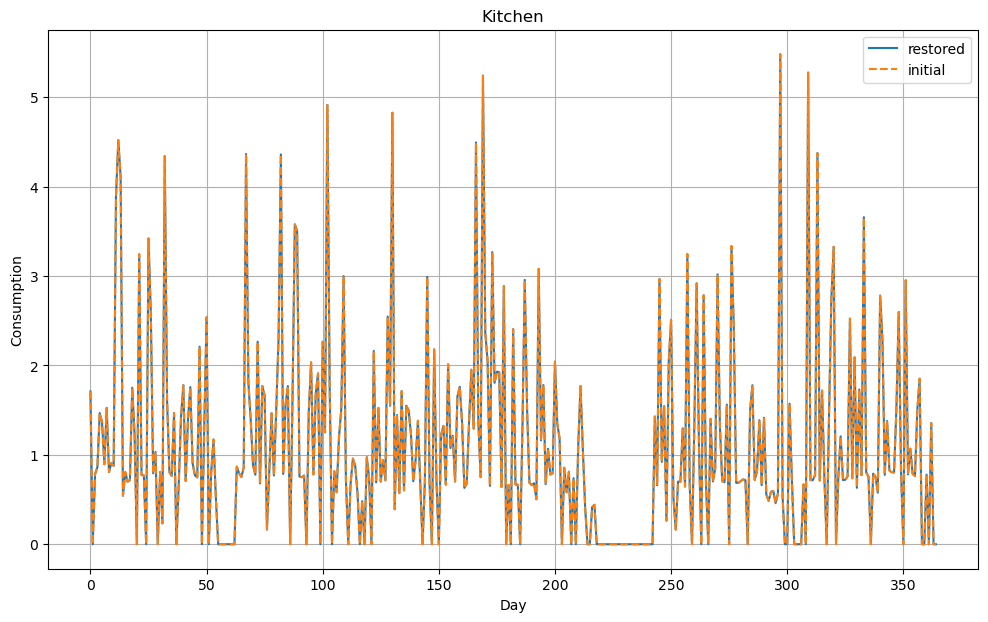

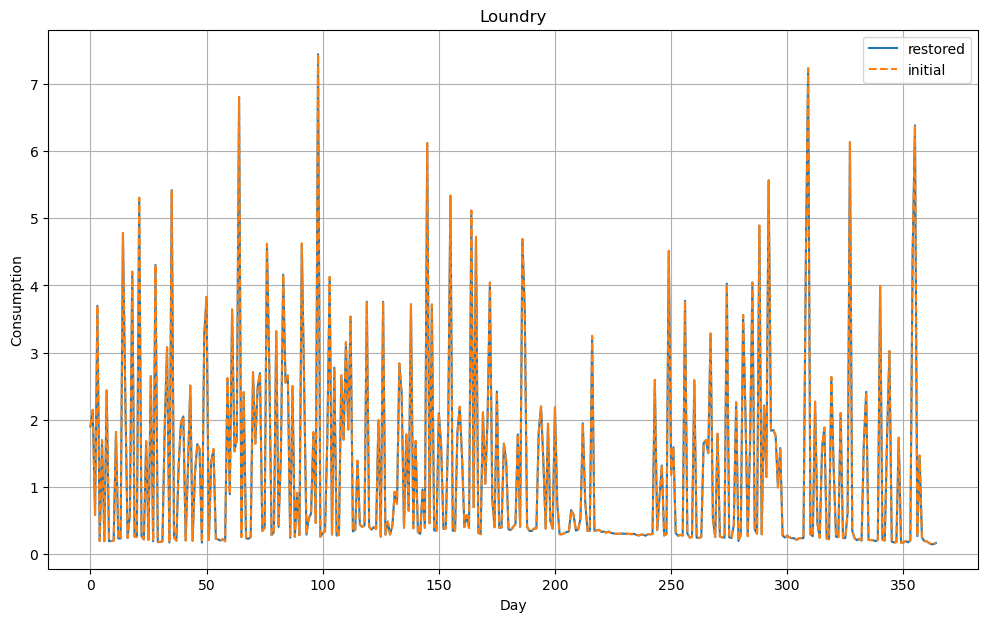

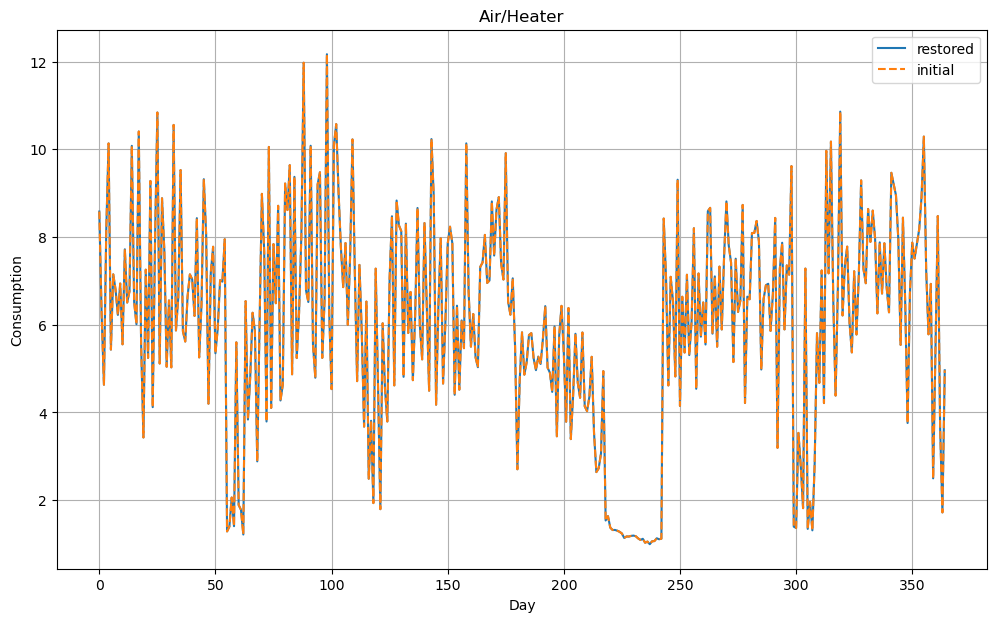

In [8]:
# have a look on the restoration
for sig_num in range(3):
    fig, ax = plt.subplots(figsize=(12, 7))

    restored_signal = np.zeros(decomposed_signals[0][0].shape)
    for i in range(len(decomposed_signals)):
        restored_signal += decomposed_signals[i][sig_num]

    ax.plot(restored_signal, label='restored')
    ax.plot(mssa_data[:end_day, sig_num].flatten(), linestyle='--', label='initial')

    ax.set_ylabel('Consumption')
    ax.set_xlabel('Day')
    ax.set_title(fig_title[sig_num])
    ax.grid()
    ax.legend()

### tSSA alorightm

Buld trajectory matrices for each 1d signal, stack them into 3d tensor, apply CPD, restore results

In [3]:
from src.multiD_ssa_v2 import multiD_sigwise_SSA_decomp

In [4]:
# cut data for the faster computations (not used)
end_day = data.shape[0]
tSSA_data = data[:end_day].copy()
np.random.seed(42)

# window size for SSA
window_size = 50
# CPD rank
cpd_rank = 5
# SSA-decomposer
decomposer = multiD_sigwise_SSA_decomp(tSSA_data.transpose(), window_size, cpd_rank)

In [5]:
# make CPD
decomposer.decompose()

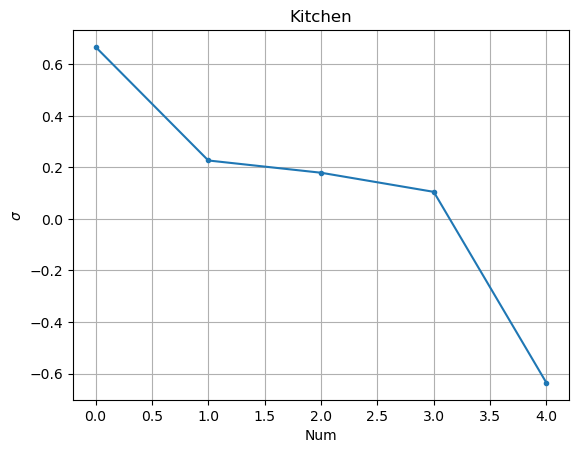

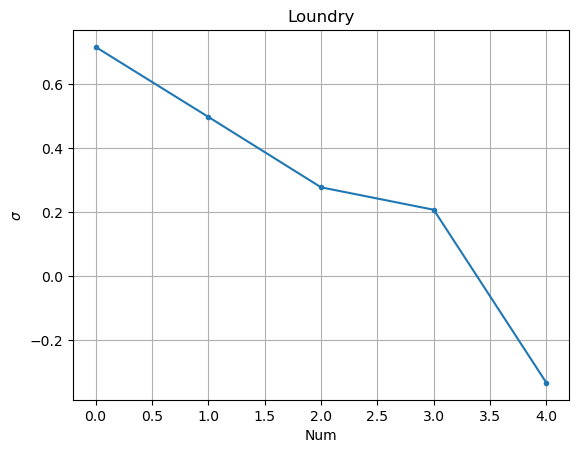

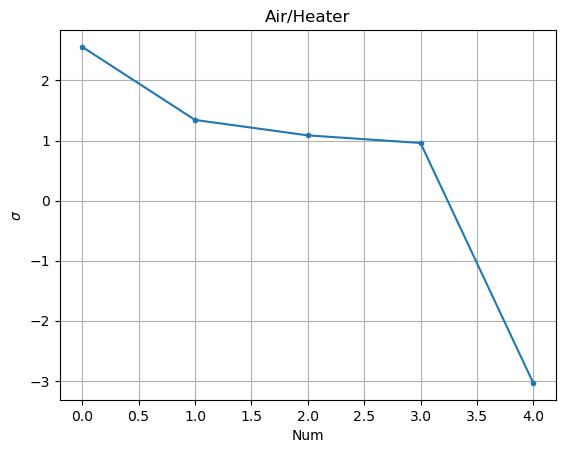

In [6]:
# let's vizualize 'singular' values for each signal
fig_title = ['Kitchen', 'Loundry', 'Air/Heater']

for sig_num in range(3):
    fig, ax = plt.subplots()
    indices_transform = decomposer.indicies_sorted[sig_num]
    ax.plot(decomposer.factors[2][sig_num][indices_transform], marker='.')
    ax.set_title(fig_title[sig_num])
    ax.set_xlabel('Num')
    ax.set_ylabel(r'$\sigma$')
    ax.grid(True)

In [7]:
# let's try group
group_kitchen = [(0,), (1, 2, 3), (4, )]
group_loundry = [(0, 1, 2), (3, ), (4, )]
group_airheat = [(0,), (1, 2, 3), (4, )]
group_list = [group_kitchen, group_loundry, group_airheat]

decomposer.group_components(group_list)

# now extract signals
decomposer.extract_signals()

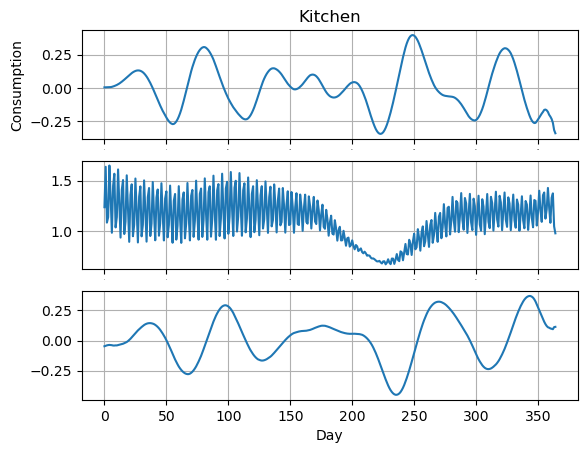

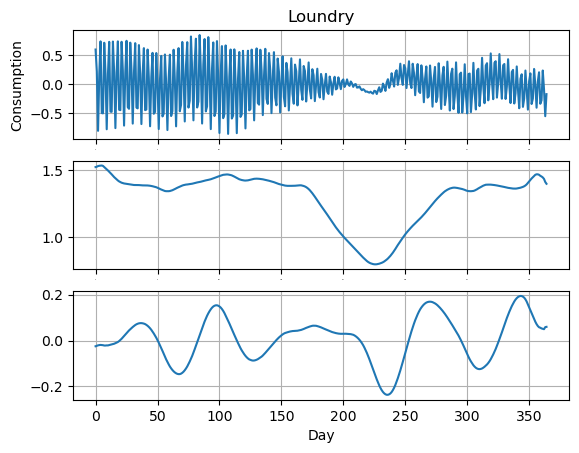

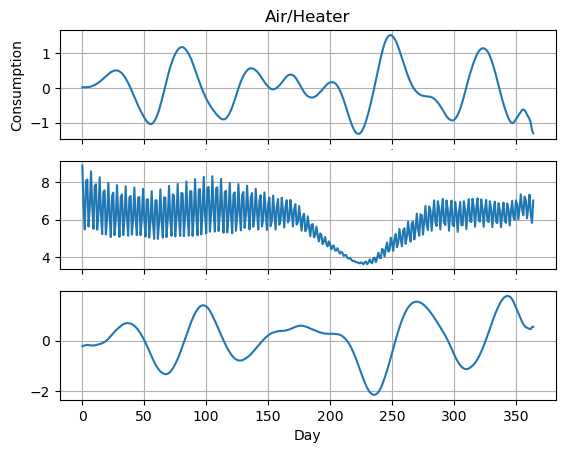

In [8]:
# visualize decompositions
decomposed_signals = decomposer.component_signals

for sig_num in range(3):
    fig, ax = plt.subplots(nrows=len(decomposed_signals[sig_num]))

    for i in range(len(decomposed_signals[sig_num])):
        ax[i].plot(decomposed_signals[sig_num][i])
        
        if i == 0:
            ax[i].set_ylabel('Consumption')
            ax[i].set_title(fig_title[sig_num])
        if i == len(decomposed_signals) - 1:
            ax[i].set_xlabel('Day')
        else:
            ax[i].tick_params(axis='x', labelsize=0)

        ax[i].grid()

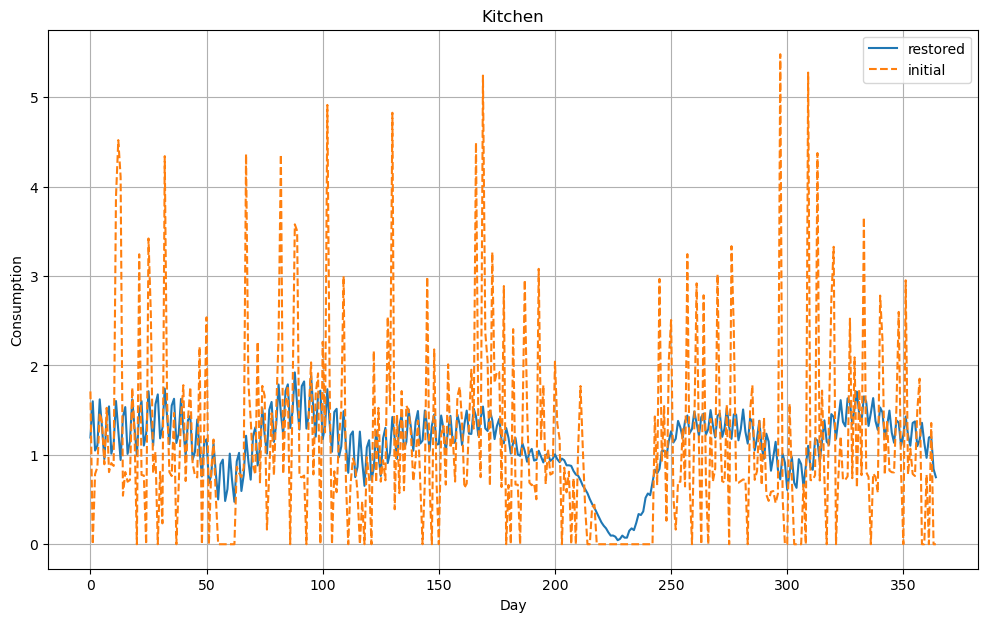

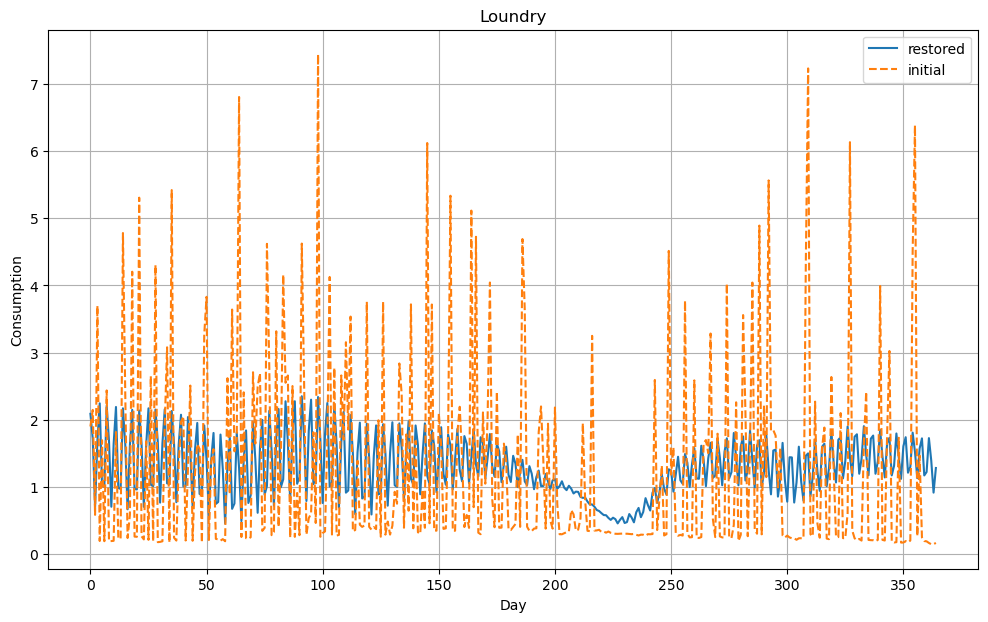

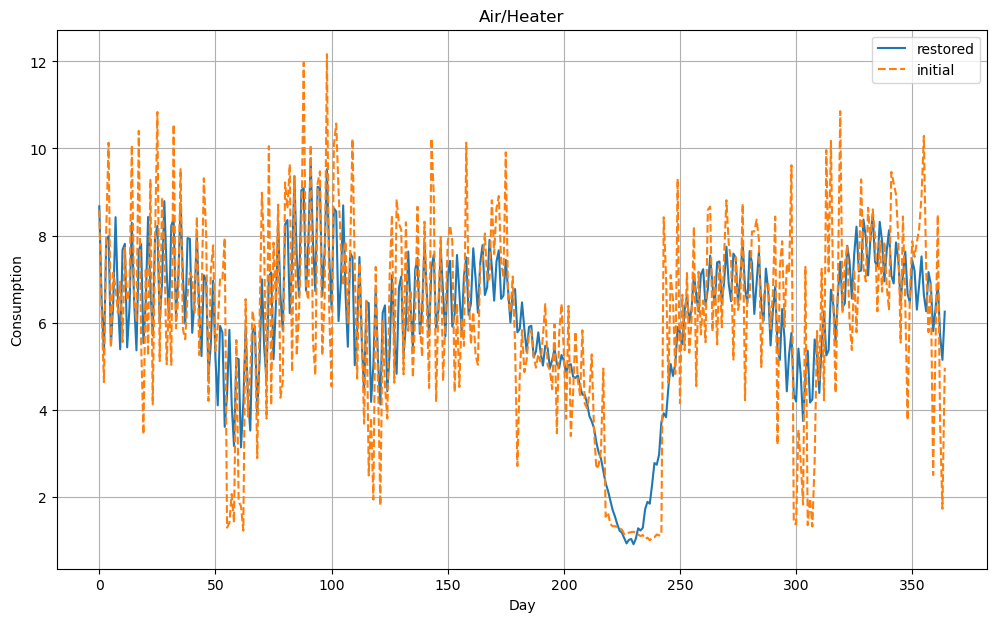

In [10]:
# have a look on the restoration
for sig_num in range(3):
    fig, ax = plt.subplots(figsize=(12, 7))

    restored_signal = np.zeros(decomposed_signals[0][0].shape)
    for i in range(len(decomposed_signals[sig_num])):
        restored_signal += decomposed_signals[sig_num][i]

    ax.plot(restored_signal, label='restored')
    ax.plot(tSSA_data[:end_day, sig_num].flatten(), linestyle='--', label='initial')

    ax.set_ylabel('Consumption')
    ax.set_xlabel('Day')
    ax.set_title(fig_title[sig_num])
    ax.grid()
    ax.legend()